Here we are going to implement an implicit finite difference method to solve the boundary value obstacle problem
\begin{align*} 
\frac{\partial u}{\partial t}(t,x) &\geq \frac{\partial^2u}{\partial x^2}(t,x)+f(t,x), 
&& 0<t<T, \quad x_L<x<x_R,\\
u(t,x)&\geq g(x)&& 0<t<T, \quad x_L<x<x_R,\\
u(0,x)&= u_0(x),&& x_L< x <x_R,\\
u(t,x_L)&= u_L(t),&& 0\leq t\leq T,\\
u(t,x_R)&= u_R(t),&& 0\leq t\leq T.
\end{align*}

In [16]:
import numpy as np
import seaborn as sns
%pylab inline
from IPython.display import HTML
from matplotlib import animation

Populating the interactive namespace from numpy and matplotlib


In [17]:
# Define the Thomas Algorithm to solve the system c_i v_{i-1}+a_i v_i+b_i v_{i+1}=f_i (v_0,v_J known)
def Thomas(v,f,a,b,c):
    # a, b, c and f are vectors with values corresponding to interior points only
    J = len(v)-1 
    ind = arange(1,J)
    # define larger vectors containing a, b, c and f
    ff = np.zeros((J+1,)); aa = np.zeros((J+1,)); bb = np.zeros((J+1,)); cc = np.zeros((J+1,));
    ff[ind] = f.copy() 
    aa[ind] = a.copy(); bb[ind] = b.copy(); cc[ind] = c.copy()
    # the algorithm
    ff[1] = ff[1] - cc[1]*v[0]
    ff[J-1] = ff[J-1] - bb[J-1]*v[J]
    for j in range(1,J-1):
        m = cc[j+1]/aa[j]
        aa[j+1] = aa[j+1] - bb[j]*m
        ff[j+1] = ff[j+1] - ff[j]*m
    v[J-1] = ff[J-1]/aa[J-1]
    for j in range(J-2,0,-1):
        v[j] = (ff[j] - bb[j]*v[j+1])/aa[j]
    del ff, aa, bb, cc, J, m, ind
    return v

In [102]:
# Define a policy iteration algorithm to solve (Au-f)(u-g)=0, Au>=f,u>=g
# where A is a tridiagonal matrix such that the i'th row of A*u is
# c_i u_{i-1}+a_i u_i+b_i u_{i+1}
def Policy(u,f,g,a,b,c):
    J = len(f)-1
    tmp = np.zeros((J-1,1))
    ind = arange(1,J)
    notconverged = True
    TOL = 1e-11
    count = 0
    while notconverged:
        tmp = c*u[ind-1]+a*u[ind]+b*u[ind+1]-f[ind]
        #print(size(tmp))
        r = np.minimum(tmp,u[ind]-g[ind])
        i = nonzero(r==tmp)
        aa = np.ones((J-1,)); bb = np.zeros((J-1,)); cc = np.zeros((J-1,))
        aa[i] = a[i]; bb[i] = b[i]; cc[i] = c[i]
        ff = g[ind].copy()
        ff[i] = f[ind[i]]
        unew = u.copy()
        unew = Thomas(unew,ff,aa,bb,cc)
        notconverged = (np.max(np.abs(u-unew)))>TOL
        u = unew.copy()
        count+=1
    #print(count)
    return u

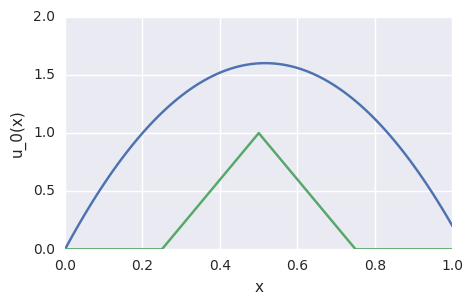

In [112]:
# We begin by setting some parameters of the problem and showing the initial datum

x_L = 0; x_R = 1; T = 0.5;
#u_0 = lambda x: np.maximum(np.sin(np.pi*x)*(x<1),0)
#u_0 = lambda x: (np.sin(2*np.pi*x))
u_0 = lambda x: 6*x*(1-x)+0.2*x
u_L = lambda t: np.zeros(np.shape(t))
u_R = lambda t: 0.2*np.ones(np.shape(t))
g = lambda x: np.maximum(1-4*np.abs(x-0.5),0)
f = lambda x: -15*np.ones(np.shape(x))
theta = 1.0

J0 = 100; # the number of intervals in the x-direction
N0 = 500; # the number of time steps
for kk in range(0,1):
    N = N0*(2**kk);
    J = J0;

    x = np.linspace(x_L,x_R,J+1);
    t = np.linspace(0,T,N+1)

    # Initialize the solution vector and compute the boundary values
    U = np.zeros((N+1,J+1));
    U[0,:] = u_0(x)

    # Plot u_0
    fig = figure(figsize=(5,3));
    line, = plot(x,U[0,:]);
    plot(x,g(x))
    xlabel('x')
    ylabel('u_0(x)');
    ylim(0,2)
    # Perform the computation
    dt = T/N; dx = (x_R-x_L)/J;
    nu = dt/dx**2
    #print('The value of nu is %f' %nu)
    ind = arange(1,J) # the indices of the interior points
    # The implicit finite difference propagation
    ii = np.ones((J-1,))
    for n in range(N):
        RHS = U[n,:].copy()
        RHS[ind] = nu*(1-theta)*(RHS[ind-1]+RHS[ind+1]-2*RHS[ind]) + RHS[ind]
        RHS = RHS + dt*f(x)
        U[n+1,:] = U[n,:].copy()
        U[n+1,0] = u_L(t[n+1]); U[n+1,-1] = u_R(t[n+1]); 
        
        #U[n+1,:] = Thomas(U[n+1,:],RHS,(1+2*nu*theta)*ii,-nu*theta*ii,-nu*theta*ii)
        U[n+1,:] = Policy(U[n+1,:],RHS,g(x),(1+2*nu*theta)*ii,-nu*theta*ii,-nu*theta*ii)
    #plot(x,U[-1,:])

    linek, = plot(x[0],g(x[0]),'k',linewidth=4)

In [113]:
# make a movie
def init():
    line.set_data(x, U[0,:])
    return (line,)
def update(n):
    line.set_data(x, U[n+1,:])
    jj = nonzero((np.abs(U[n+1,:]-g(x))<1e-6)*(g(x)>0))
    linek.set_data(x[jj],U[n+1,jj])
    return (line,linek)
anim = animation.FuncAnimation(fig, update, init_func=init,
                               frames=N, interval=50, blit=True, repeat=False)
HTML(anim.to_html5_video())